## LSTM

In [1]:
from preprocess_data import get_HITL, clean_HITL
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

random_state = 42


In [2]:
hitl_dict = get_HITL("../../data/HardwareInTheLoop/", small=True)
df_network, df_physical = clean_HITL(hitl_dict) # Clean-up helper function

print("Network dataset shape: ", df_network.shape)
print("Physical dataset shape: ", df_physical.shape)

Network dataset shape:  (243065, 17)
Physical dataset shape:  (9206, 44)


In [3]:
df_network_labels = df_network[["label_n", "label", "attack"]]
df_network = df_network.drop(columns=["label", "label_n", "attack"])
df_network_labels.head()

,label_n,label,attack
0,0,normal,1
1,0,normal,1
2,0,normal,1
3,0,normal,1
4,0,normal,1


In [4]:
from mlsecu.data_exploration_utils import get_column_names, get_nb_of_dimensions, get_nb_of_rows, get_object_column_names, get_number_column_names
from mlsecu.anomaly_detection_use_case import *
from mlsecu.data_preparation_utils import get_one_hot_encoded_dataframe, remove_nan_through_mean_imputation

Let's just be sure that we are not omitting any important column

In [5]:
assert(len(get_number_column_names(df_network)) + len(get_object_column_names(df_network)) == len(df_network.columns))

In [6]:
df_network[get_number_column_names(df_network)]

,time,sport,dport,flags,size,n_pkt_src,n_pkt_dst
0,1.617993e+09,56666.0,502.0,11000.0,66,50.0,15.0
1,1.617993e+09,502.0,56666.0,11000.0,64,15.0,50.0
2,1.617993e+09,56668.0,502.0,11000.0,66,50.0,15.0
3,1.617993e+09,502.0,56668.0,11000.0,65,15.0,50.0
4,1.617993e+09,502.0,56666.0,11000.0,65,15.0,50.0
...,...,...,...,...,...,...,...
243060,1.617971e+09,61516.0,502.0,11000.0,66,50.0,15.0
243061,1.617971e+09,61516.0,502.0,11000.0,66,50.0,15.0
243062,1.617971e+09,61517.0,502.0,11000.0,66,51.0,14.0
243063,1.617971e+09,61515.0,502.0,11000.0,66,47.0,14.0


In [7]:
df_network[get_object_column_names(df_network)]

,mac_s,mac_d,ip_s,ip_d,proto,modbus_fn,modbus_response
0,74:46:a0:bd:a7:1b,e6:3f:ac:c9:a8:8c,84.3.251.20,84.3.251.101,Modbus,Read Holding Registers,NaN
1,e6:3f:ac:c9:a8:8c,74:46:a0:bd:a7:1b,84.3.251.101,84.3.251.20,Modbus,Read Coils Response,[0]
2,74:46:a0:bd:a7:1b,fa:00:bc:90:d7:fa,84.3.251.20,84.3.251.103,Modbus,Read Holding Registers,NaN
3,fa:00:bc:90:d7:fa,74:46:a0:bd:a7:1b,84.3.251.103,84.3.251.20,Modbus,Read Holding Registers Response,[0]
4,e6:3f:ac:c9:a8:8c,74:46:a0:bd:a7:1b,84.3.251.101,84.3.251.20,Modbus,Read Holding Registers Response,[0]
...,...,...,...,...,...,...,...
243060,74:46:a0:bd:a7:1b,fa:00:bc:90:d7:fa,84.3.251.20,84.3.251.103,Modbus,Read Holding Registers,NaN
243061,74:46:a0:bd:a7:1b,fa:00:bc:90:d7:fa,84.3.251.20,84.3.251.103,Modbus,Read Holding Registers,NaN
243062,74:46:a0:bd:a7:1b,0a:fe:ec:47:74:fb,84.3.251.20,84.3.251.102,Modbus,Read Holding Registers,NaN
243063,74:46:a0:bd:a7:1b,e6:3f:ac:c9:a8:8c,84.3.251.20,84.3.251.101,Modbus,Read Holding Registers,NaN


##### Remove NaN values for both numerical and categorical columns

In [8]:
df_number_network = remove_nan_through_mean_imputation(df_network[get_number_column_names(df_network)])
df_number_network

,time,sport,dport,flags,size,n_pkt_src,n_pkt_dst
0,1.617993e+09,56666.0,502.0,11000.0,66,50.0,15.0
1,1.617993e+09,502.0,56666.0,11000.0,64,15.0,50.0
2,1.617993e+09,56668.0,502.0,11000.0,66,50.0,15.0
3,1.617993e+09,502.0,56668.0,11000.0,65,15.0,50.0
4,1.617993e+09,502.0,56666.0,11000.0,65,15.0,50.0
...,...,...,...,...,...,...,...
243060,1.617971e+09,61516.0,502.0,11000.0,66,50.0,15.0
243061,1.617971e+09,61516.0,502.0,11000.0,66,50.0,15.0
243062,1.617971e+09,61517.0,502.0,11000.0,66,51.0,14.0
243063,1.617971e+09,61515.0,502.0,11000.0,66,47.0,14.0


The two categorical columns with NaN values are `modbus_response` and `modbus_fn`. Let's replace the NaN values with empty strings

In [9]:
df_object_network = df_network[get_object_column_names(df_network)].fillna("")
df_object_network

,mac_s,mac_d,ip_s,ip_d,proto,modbus_fn,modbus_response
0,74:46:a0:bd:a7:1b,e6:3f:ac:c9:a8:8c,84.3.251.20,84.3.251.101,Modbus,Read Holding Registers,
1,e6:3f:ac:c9:a8:8c,74:46:a0:bd:a7:1b,84.3.251.101,84.3.251.20,Modbus,Read Coils Response,[0]
2,74:46:a0:bd:a7:1b,fa:00:bc:90:d7:fa,84.3.251.20,84.3.251.103,Modbus,Read Holding Registers,
3,fa:00:bc:90:d7:fa,74:46:a0:bd:a7:1b,84.3.251.103,84.3.251.20,Modbus,Read Holding Registers Response,[0]
4,e6:3f:ac:c9:a8:8c,74:46:a0:bd:a7:1b,84.3.251.101,84.3.251.20,Modbus,Read Holding Registers Response,[0]
...,...,...,...,...,...,...,...
243060,74:46:a0:bd:a7:1b,fa:00:bc:90:d7:fa,84.3.251.20,84.3.251.103,Modbus,Read Holding Registers,
243061,74:46:a0:bd:a7:1b,fa:00:bc:90:d7:fa,84.3.251.20,84.3.251.103,Modbus,Read Holding Registers,
243062,74:46:a0:bd:a7:1b,0a:fe:ec:47:74:fb,84.3.251.20,84.3.251.102,Modbus,Read Holding Registers,
243063,74:46:a0:bd:a7:1b,e6:3f:ac:c9:a8:8c,84.3.251.20,84.3.251.101,Modbus,Read Holding Registers,


##### Encode categorical columns

For each categorical column, let's one-hot encode them

Merge the two sub-datasets

In [10]:
df_network_prepared = pd.concat([df_number_network, df_object_network], axis=1)
df_network_prepared.head()

,time,sport,dport,flags,size,n_pkt_src,n_pkt_dst,mac_s,mac_d,ip_s,ip_d,proto,modbus_fn,modbus_response
0,1.617993e+09,56666.0,502.0,11000.0,66,50.0,15.0,74:46:a0:bd:a7:1b,e6:3f:ac:c9:a8:8c,84.3.251.20,84.3.251.101,Modbus,Read Holding Registers,
1,1.617993e+09,502.0,56666.0,11000.0,64,15.0,50.0,e6:3f:ac:c9:a8:8c,74:46:a0:bd:a7:1b,84.3.251.101,84.3.251.20,Modbus,Read Coils Response,[0]
2,1.617993e+09,56668.0,502.0,11000.0,66,50.0,15.0,74:46:a0:bd:a7:1b,fa:00:bc:90:d7:fa,84.3.251.20,84.3.251.103,Modbus,Read Holding Registers,
3,1.617993e+09,502.0,56668.0,11000.0,65,15.0,50.0,fa:00:bc:90:d7:fa,74:46:a0:bd:a7:1b,84.3.251.103,84.3.251.20,Modbus,Read Holding Registers Response,[0]
4,1.617993e+09,502.0,56666.0,11000.0,65,15.0,50.0,e6:3f:ac:c9:a8:8c,74:46:a0:bd:a7:1b,84.3.251.101,84.3.251.20,Modbus,Read Holding Registers Response,[0]


In [11]:
df_network_prepared.reset_index(drop=True, inplace=True)

In [12]:
# one hot encoding of categorical features
one_hot_df = get_one_hot_encoded_dataframe(df_network_prepared[get_object_column_names(df_network_prepared)])

# merge one hot encoded categorical features with numerical features
df_network_prepared = pd.concat([df_network_prepared[get_number_column_names(df_network_prepared)], one_hot_df], axis=1)
df_network_prepared.head()

,time,sport,dport,flags,size,n_pkt_src,n_pkt_dst,mac_s_00:0c:29:47:8c:22,mac_s_00:80:f4:03:fb:12,mac_s_0a:fe:ec:47:74:fb,...,modbus_response_[985],modbus_response_[988],modbus_response_[98],modbus_response_[991],modbus_response_[993],modbus_response_[994],modbus_response_[995],modbus_response_[999],modbus_response_[99],modbus_response_[9]
0,1.617993e+09,56666.0,502.0,11000.0,66,50.0,15.0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1.617993e+09,502.0,56666.0,11000.0,64,15.0,50.0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1.617993e+09,56668.0,502.0,11000.0,66,50.0,15.0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1.617993e+09,502.0,56668.0,11000.0,65,15.0,50.0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1.617993e+09,502.0,56666.0,11000.0,65,15.0,50.0,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [13]:
def update_labels(df_labels):
    df_labels = df_labels.reset_index(drop=True)

    df_labels["new_labels"] = df_labels["label"].astype('category').cat.codes

    return df_labels

df_network_labels = update_labels(df_network_labels)

In [14]:
# Prepare train and test datasets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_network_prepared, df_network_labels[["new_labels", "label_n"]], test_size=0.2, random_state=random_state)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((194452, 1986), (48613, 1986), (194452, 2), (48613, 2))

In [15]:
# Preprocess X_train and X_test
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
# Create pytorch dataset
import torch

class HITLDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X).float()
        self.y = torch.tensor(y).long()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # print(self.X.shape)
        # print(idx)
        return self.X[idx], self.y[idx]


train_dataset = HITLDataset(X_train_scaled, y_train["label_n"].to_numpy())
test_dataset = HITLDataset(X_test_scaled, y_test["label_n"].to_numpy())

# Create pytorch dataloader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [17]:
# Create LSTM
import torch.nn as nn
import torch.nn.functional as F

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out)
        return out
    
# Create model
input_dim = X_train_scaled.shape[1]
output_dim = len(y_train["label_n"].unique()) # 2
hidden_dim = 32
model = LSTM(input_dim, hidden_dim, output_dim)
model

LSTM(
  (lstm): LSTM(1986, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=2, bias=True)
)

In [18]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [19]:
from tqdm import tqdm

def train(model, train_loader, criterion, optimizer):
    model.train()
    train_loss = 0
    train_acc = 0
    for X, y in tqdm(train_loader, total=len(train_loader)):
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (y_pred.argmax(1) == y).sum().item()
    return train_loss / len(train_loader), train_acc / len(train_loader.dataset)

def test(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    test_acc = 0
    y_pred_list = []
    y_true_list = []
    with torch.no_grad():
        for X, y in test_loader:
            y_pred = model(X)
            loss = criterion(y_pred, y)
            test_loss += loss.item()
            test_acc += (y_pred.argmax(1) == y).sum().item()
            y_pred_list.append(y_pred.argmax(1).cpu().numpy())
            y_true_list.append(y.cpu().numpy())
    return test_loss / len(test_loader), test_acc / len(test_loader.dataset)



### Train on two labels (attack or not)

100%|██████████| 6077/6077 [00:37<00:00, 163.53it/s]


Train loss: 0.3712, Train acc: 0.8636


100%|██████████| 6077/6077 [00:35<00:00, 169.92it/s]


Train loss: 0.3370, Train acc: 0.8741


100%|██████████| 6077/6077 [00:35<00:00, 170.46it/s]


Train loss: 0.3173, Train acc: 0.8752


100%|██████████| 6077/6077 [00:38<00:00, 157.14it/s]


Train loss: 0.3062, Train acc: 0.8753


100%|██████████| 6077/6077 [00:43<00:00, 138.19it/s]


Train loss: 0.2996, Train acc: 0.8753


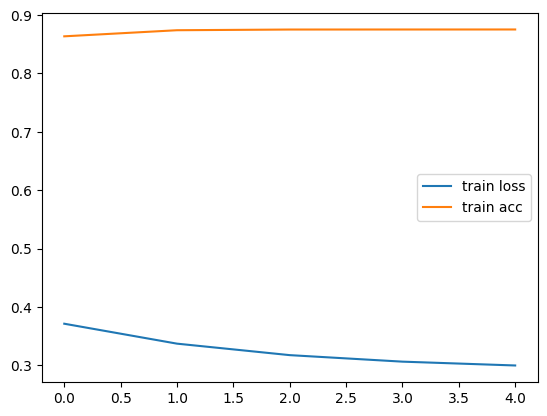

In [20]:
EPOCHS = 5
train_loss_list = []
train_acc_list = []

for _ in range(EPOCHS):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    print(f"Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}")

# Plot train loss and accuracy
plt.plot(train_loss_list, label="train loss")
plt.plot(train_acc_list, label="train acc")
plt.legend()
plt.show()


In [21]:

test_loss, test_acc = test(model, test_loader, criterion)
print(f"Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")


Test loss: 0.3089, Test acc: 0.8670


### Train on types of attacks (DoS, MITM, etc.) (total 5 labels, normal is 3)

In [22]:
# Create pytorch dataset
train_dataset = HITLDataset(X_train_scaled, y_train["new_labels"].to_numpy())
test_dataset = HITLDataset(X_test_scaled, y_test["new_labels"].to_numpy())

# Create pytorch dataloader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [23]:
# Create LSTM
import torch.nn as nn
import torch.nn.functional as F

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out)
        return out
    
# Create model
input_dim = X_train_scaled.shape[1]
output_dim = len(y_train["new_labels"].unique())
hidden_dim = 32
model = LSTM(input_dim, hidden_dim, output_dim)
model

LSTM(
  (lstm): LSTM(1986, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=5, bias=True)
)

In [24]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

100%|██████████| 6077/6077 [00:42<00:00, 142.61it/s]


Train loss: 0.4953, Train acc: 0.8646


100%|██████████| 6077/6077 [00:38<00:00, 159.53it/s]


Train loss: 0.4427, Train acc: 0.8745


100%|██████████| 6077/6077 [00:38<00:00, 157.19it/s]


Train loss: 0.4282, Train acc: 0.8758


100%|██████████| 6077/6077 [00:45<00:00, 132.54it/s]


Train loss: 0.4126, Train acc: 0.8767


100%|██████████| 6077/6077 [00:44<00:00, 136.30it/s]


Train loss: 0.3982, Train acc: 0.8773


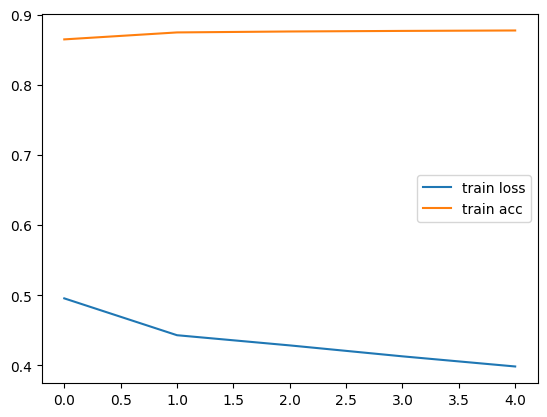

In [25]:
EPOCHS = 5
train_loss_list = []
train_acc_list = []

for _ in range(EPOCHS):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    print(f"Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}")

# Plot train loss and accuracy
plt.plot(train_loss_list, label="train loss")
plt.plot(train_acc_list, label="train acc")
plt.legend()
plt.show()


In [26]:

test_loss, test_acc = test(model, test_loader, criterion)
print(f"Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")


Test loss: 0.3966, Test acc: 0.8780
